<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/Poisson_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

c3493e9a0d84


In [2]:
!nvidia-smi

Mon Sep 19 18:10:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install torch sdeint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sdeint: filename=sdeint-0.3.0-py3-none-any.whl size=25907 sha256=d969dfa731818830d07c58a1c675888a94d31c6b8a06e4015f58a1162da1304c
  Stored in directory: /root/.cache/pip/wheels/64/30/eb/70e285284253db9252d1dcdc6cea14cc860d95e7ed201efd9d
Successfully built sdeint


In [4]:
# check out SINN model from repo
!git clone https://github.com/SINN-model/SINN.git
!cp SINN/toolbox . -r

Cloning into 'SINN'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 8), reused 12 (delta 4), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [5]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [6]:
device = torch.device('cuda')

In [7]:
def Poisson_process_noise_generator(batch_size, num_steps, r, la):

    N = np.random.poisson(la, (batch_size, num_steps + 2))
    loc = N.cumsum(axis=1)
    M = loc[:, -1].max()
    R = np.random.exponential(r, (batch_size, M + 1))
    R_cumulative = R.cumsum(axis=1)

    xi = np.array([r[l[1:-1]] - r[l[0:-2]] for r, l in zip(R_cumulative, loc)])

    return xi

400.0
(2001, 400)


(1500, 400)
(400, 400) (400, 400)
CPU times: user 2.11 s, sys: 45.3 ms, total: 2.16 s
Wall time: 2.18 s


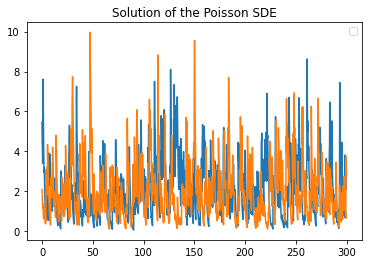

In [8]:
%%time

#### Generating SINN training data by solving SDE driven by Poisson noise 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad

#### Parameters 
mag=1                # Magnitude of the poisson white noise
gamma=1              # Harmonic potential U(x)=gamma*x^2/2  
lambda_p=2           # Poisson distribution lambda
r=1                  # Exponential distribution r
dt=0.01 
delta_t= 0.2
batch = 400
sec_length = 400


#### SDE solver (EM scheme) with Poisson noise generator
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q_store = np.zeros([t_store.size+1,batch])
print(q_store.shape)
q0=np.zeros((1,batch))
q1=np.zeros((1,batch))
# solve Poisson SDE
j=0
for i in range(1,length):
    q1 = q0 - gamma*q0*dt+ mag*Poisson_process_noise_generator(1,batch,r,lambda_p*dt)
    if i % gap ==0:
        q_store[j,:]=q1
        j=j+1
    q0=q1

Toss=int(t_store.size/4)        
q_store=q_store[Toss:-1,:]         
print(q_store.shape)

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
plt.legend()
plt.title("Solution of the Poisson SDE")


# Construct the sample traj for SINN learning 
ini=np.random.exponential(1,(sec_length,batch))
Traj=q_store[0:sec_length,:]
T=np.arange(len(Traj[:,1]))*delta_t
print(ini.shape, Traj.shape)
x=np.linspace(0,10,sec_length)




In [9]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini=np.random.exponential(1,(2*sec_length,batch)).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)

batch_validation = batch
val=np.random.exponential(1,(2*sec_length,batch_validation)).astype(np.float32) 
val_set = torch.from_numpy(val.reshape(2*sec_length, batch_validation,1)).to(device)

Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch,1)).to(device)

print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 1]) torch.float32


In [10]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=0, upper=10, n=N, device=device)

/content/toolbox/_loss.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._target = torch.tensor(target, dtype=torch.float32, device=device)


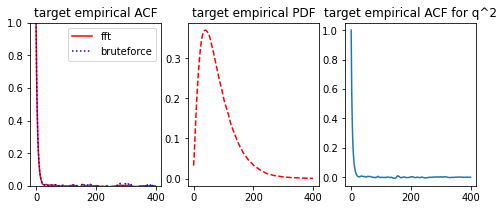

In [11]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r', label='fft')
axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].set_ylim([0,1])
x_grid=-np.linspace(-5,5,num=sec_length)
axs[1].plot(loss_pdf_empirical._target.cpu(),'r--')
axs[1].set_title('target empirical PDF')
axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title('target empirical ACF for q^2')
axs[0].legend()
plt.show()

In [12]:
### Defining SINN model
net = SINN(1, 5, 2, 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [13]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini=np.random.exponential(1,(2*sec_length,batch)).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0005 and loss_val<=0.0005:
            break
print('Training finished')

[0]-th step loss: 0.054, 0.052
[50]-th step loss: 0.026, 0.026
[100]-th step loss: 0.025, 0.025
[150]-th step loss: 0.025, 0.025
[200]-th step loss: 0.025, 0.025
[250]-th step loss: 0.025, 0.025
[300]-th step loss: 0.025, 0.025
[350]-th step loss: 0.025, 0.025
[400]-th step loss: 0.025, 0.025
[450]-th step loss: 0.025, 0.025
[500]-th step loss: 0.025, 0.025
[550]-th step loss: 0.025, 0.025
[600]-th step loss: 0.025, 0.025
[650]-th step loss: 0.025, 0.025
[700]-th step loss: 0.025, 0.025
[750]-th step loss: 0.025, 0.025
[800]-th step loss: 0.025, 0.025
[850]-th step loss: 0.025, 0.025
[900]-th step loss: 0.025, 0.025
[950]-th step loss: 0.025, 0.025
[1000]-th step loss: 0.025, 0.025
[1050]-th step loss: 0.025, 0.025
[1100]-th step loss: 0.025, 0.025
[1150]-th step loss: 0.025, 0.025
[1200]-th step loss: 0.025, 0.025
[1250]-th step loss: 0.025, 0.025
[1300]-th step loss: 0.025, 0.025
[1350]-th step loss: 0.025, 0.025
[1400]-th step loss: 0.025, 0.025
[1450]-th step loss: 0.025, 0.025
[15

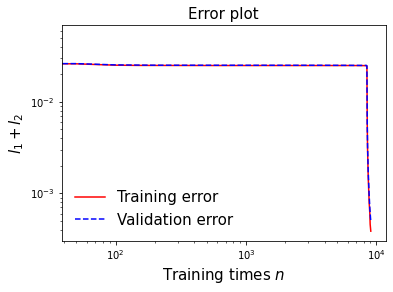

In [14]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/Poisson_training_error.pdf", dpi=150)


In [15]:
## Exponentially distributed random input (newly generated)
ran_ini = np.random.exponential(1,(2*sec_length,batch)).astype(np.float32) 
ran_input = torch.from_numpy(ran_ini.reshape(2*sec_length, batch,1)).to(device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x7fac80242250>,
 <a list of 6 Text major ticklabel objects>)

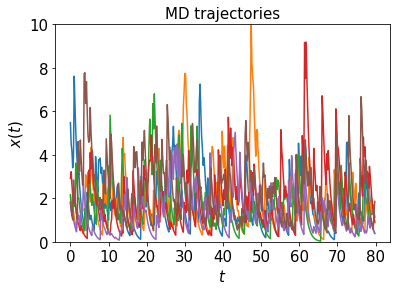

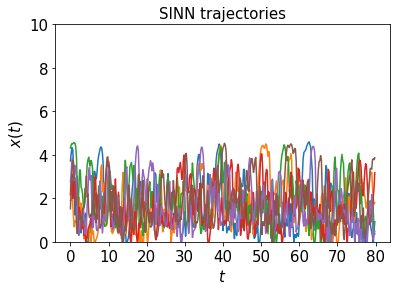

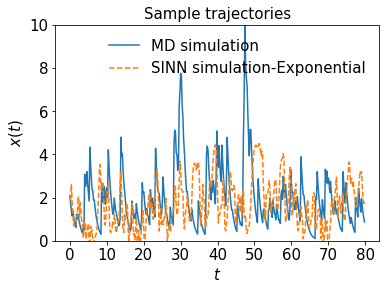

In [16]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

plt.figure(0) 
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.plot(T[skip:]-T[skip], Traj[skip:, 2])
plt.plot(T[skip:]-T[skip], Traj[skip:, -1])
plt.plot(T[skip:]-T[skip], Traj[skip:, -2])
plt.plot(T[skip:]-T[skip], Traj[skip:, -3])    
plt.ylim([0,10])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     


plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.plot(T[skip:]-T[skip], prediction[skip:, -1])
plt.plot(T[skip:]-T[skip], prediction[skip:, -2])
plt.plot(T[skip:]-T[skip], prediction[skip:, -3])
plt.ylim([0,10])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 1],'--',label='SINN simulation-Exponential')
plt.ylim([0,10])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([0,2,4,6,8,10],fontsize=15)
# plt.savefig("figs/Poisson_traj.pdf", dpi=150)





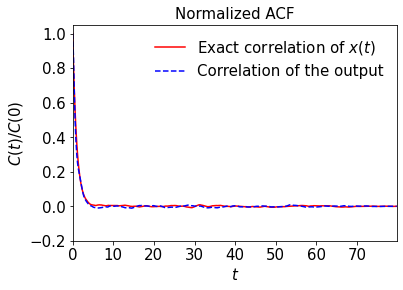

In [17]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

# acf_p=StatLoss.acf(Pred[-sec_length:,:,:],method='bruteforce')
acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/Poisson_acf.pdf", dpi=150)





(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

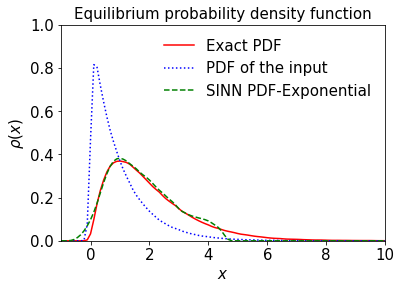

In [18]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -1, 10, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -1, 10, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -1, 10, 100).cpu()


x=np.linspace(-1, 10, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'SINN PDF-Exponential')  # PDF after the training 
plt.xlim(-1,10)
plt.ylim(0,1)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/Poisson_pdf.pdf", dpi=150)


# ###### Save the PDF data 
# from tempfile import TemporaryFile
# Poisson_PDF_Exponential = TemporaryFile()
# rho_pred_Exp=rho_prediction.numpy()
# np.savez('Poisson_PDF_Exponential.npz', x, rho_pred_Exp)


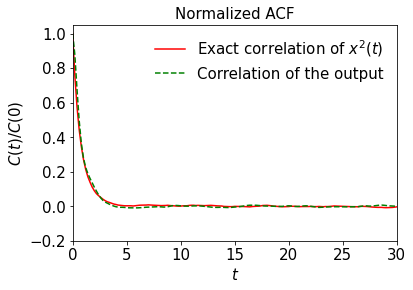

In [19]:
# Test 4: Comparing the higher-order ACF

acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/Poisson_acf2.pdf", dpi=150)




(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text major ticklabel objects>)

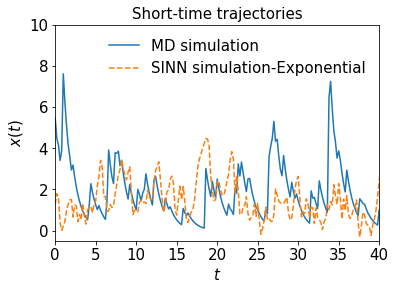

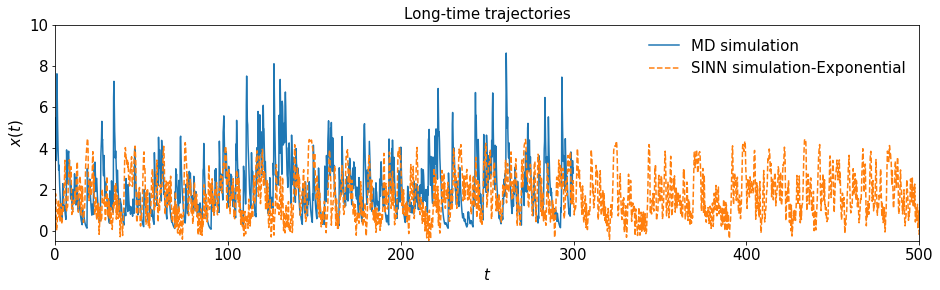

In [21]:
# Test 5: plot the expolation result, i.e. Prediction of the Poisson SDE for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50

ran_ini = np.random.exponential(1,((scale-burnin)*a,batch_new,c)).astype(np.float32) 
ran_input = torch.from_numpy(ran_ini.reshape((scale-burnin)*a, batch_new,c)).to(device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation-Exponential')
plt.xlim([0,40])
plt.ylim([-0.5,10])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([0,2,4,6,8,10],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/Poisson_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation-Exponential')
plt.xlim([0,500])
plt.ylim([-0.5,10])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([0,2,4,6,8,10],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/Poisson_traj_lT.pdf", dpi=150)



